<a href="https://colab.research.google.com/github/sadidoll/Artifical-Interlligence/blob/master/HW_4/Homework4_p3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Problem 3**
You will adapt the notebook using VGG16 conv base for feature extraction, using data augmentation, not using dropout, fine-tuning. You will have to replace the VGG16 conv base by new conv bases. You should not use VGG19.

You should create two notebooks. Both should use the same conv base, unfreeze the same number of layers of the conv_base, but use different classifiers.

##Fine-tuning Xception

This is based on section 5.3 Using a pretrained convnet of the book Deep learning with Python by Francois Chollet. 

###Feature extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the Xception model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers

###Download the data
Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in /tmp.

In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 00:12:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:80e::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   288MB/s    in 0.2s    

2020-04-22 00:12:03 (288 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

###Build network with Xception convolution base and custom densely connected layers

###Load the convolutional base

In [19]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

83689472/83683744 [==============================] - 2s 0us/step


###Freeze the convolutional base

In [0]:
conv_base.trainable = False

###Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


##Train the model end to end with frozen convolutional base

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 24s 241ms/step - loss: 0.4636 - acc: 0.7780 - val_loss: 0.1889 - val_acc: 0.9630
Epoch 2/30
100/100 [==============================] - 20s 201ms/step - loss: 0.3663 - acc: 0.8290 - val_loss: 0.3165 - val_acc: 0.9530
Epoch 3/30
100/100 [==============================] - 20s 203ms/step - loss: 0.3730 - acc: 0.8275 - val_loss: 0.1638 - val_acc: 0.9440
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3263 - acc: 0.8495 - val_loss: 0.2719 - val_acc: 0.9540
Epoch 5/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3427 - acc: 0.8420 - val_loss: 0.0441 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3390 - acc: 0.8420 - val_loss: 0.0546 - val_acc: 0.9620
Epoch 7/30
100/100 [==============================] - 20s 202ms/step - loss: 0.3228 - acc: 0.8600 - val_lo

###Display curves of loss and accuracy during training

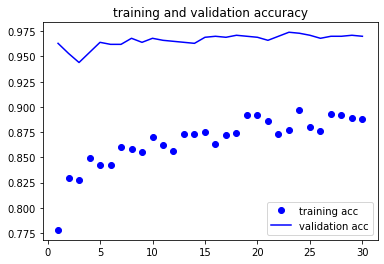

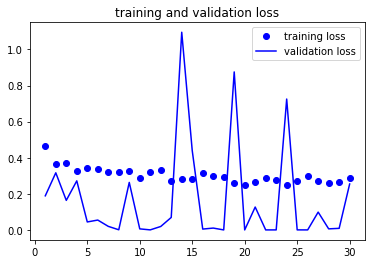

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

##Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block2_speconv2_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [26]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 239ms/step - loss: 0.2646 - acc: 0.8900 - val_loss: 0.1738 - val_acc: 0.9480
Epoch 2/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2621 - acc: 0.8840 - val_loss: 0.1271 - val_acc: 0.9290
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.2774 - acc: 0.8895 - val_loss: 0.3195 - val_acc: 0.9410
Epoch 4/100
100/100 [==============================] - 20s 200ms/step - loss: 0.2573 - acc: 0.8970 - val_loss: 0.2712 - val_acc: 0.9400
Epoch 5/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2413 - acc: 0.9065 - val_loss: 0.2637 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2665 - acc: 0.8890 - val_loss: 0.1088 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 20s 202ms/step - loss: 0.2649 - acc: 0.8885 - val_loss: 0.0118 - val_acc: 0.9370
Epoch 8/100
100/100 [===========================

##Display learning curves during fine-tuning

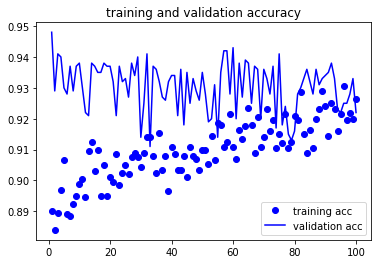

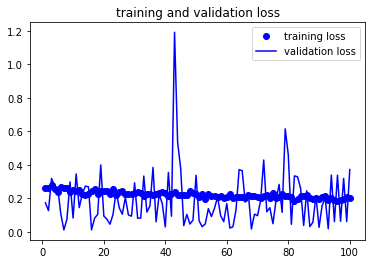

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

##Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [31]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.08211319148540497
Validation accuracy: 0.921999990940094


##Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)